In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy.signal import medfilt
from astropy.wcs import WCS
import scipy.integrate as integrate
import re

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/SDSSJ0820/HST_images/'

Load in the quasar and the alignment star

In [3]:
with open(rootdir+'alignment_stars.reg', 'r') as file:
    qso_star_lines = [line.rstrip() for line in file]

In [4]:
star_lines = []

for l in qso_star_lines:
    if 'circle' in l:
        if 'cyan' in l:
            qso_line = l
        else:
            star_lines.append(l)

In [5]:
qso_ra = np.float_(qso_line.split(',')[0][7:])
qso_dec = np.float_(qso_line.split(',')[1])

In [6]:
star_ra_list = []
star_dec_list = []

for i in range(len(star_lines)):
    star_ra_list.append(star_lines[i].split(',')[0][7:])
    star_dec_list.append(star_lines[i].split(',')[1])

Load in the photometry catalog

In [7]:
df = pd.read_csv(rootdir+'f814w_photometry.dat')

In [8]:
df

,ID,RA,Dec,f814w_mag
0,1,125.201927,3.961462,19.31
1,2,125.195620,3.945078,17.09
2,3,125.192319,3.939630,17.35
3,4,125.190413,3.934016,22.88
4,5,125.190404,3.933479,17.64
...,...,...,...,...
11592,53,125.150662,3.975402,27.08
11593,54,125.163473,3.993751,28.42
11594,55,125.169464,4.002043,27.41
11595,56,125.171514,4.004531,27.12


Identify the alignment stars in the catalog

In [9]:
def calc_phi(alpha_1, delta_1, alpha_2, delta_2):
    
    cos_phi = np.dot([np.cos(delta_1)*np.cos(alpha_1), np.cos(delta_1)*np.sin(alpha_1), np.sin(delta_1)],
                      [np.cos(delta_2)*np.cos(alpha_2), np.cos(delta_2)*np.sin(alpha_2), np.sin(delta_2)])
    
    phi = np.arccos(cos_phi)
    
    return phi

In [10]:
df['alignment_star'] = -1*np.ones(len(df))

In [11]:
for i in range(len(star_ra_list)):
    
    star_ra = Angle(star_ra_list[i], units.deg).rad
    star_dec = Angle(star_dec_list[i], units.deg).rad
    
    phi_arr = np.zeros(len(df))
    
    for j in range(len(df)):
        
        ra = Angle(df.loc[j, 'RA'], units.deg).rad
        dec = Angle(df.loc[j, 'Dec'], units.deg).rad
        
        phi = (calc_phi(star_ra, star_dec, ra, dec)*units.rad).to(units.arcsecond).value
        
        phi_arr[j] = phi
        
    df.loc[np.argmin(phi_arr), 'alignment_star'] = 1.0

Compute distances of all objects from the quasar

In [12]:
df['theta'] = -1*np.ones(len(df))

In [13]:
theta_arr = np.zeros(len(df))

for i in range(len(df)):

    ra = Angle(df.loc[i, 'RA'], units.deg).rad
    dec = Angle(df.loc[i, 'Dec'], units.deg).rad    
    
    theta_arr[i] = (calc_phi(ra, dec, qso_ra*np.pi/180, qso_dec*np.pi/180)*units.rad).to(units.arcsecond).value
    
df['theta'] = theta_arr

In [14]:
df

,ID,RA,Dec,f814w_mag,alignment_star,theta
0,1,125.201927,3.961462,19.31,-1.0,27.037703
1,2,125.195620,3.945078,17.09,1.0,58.388870
2,3,125.192319,3.939630,17.35,1.0,78.198202
3,4,125.190413,3.934016,22.88,-1.0,99.090061
4,5,125.190404,3.933479,17.64,1.0,101.006188
...,...,...,...,...,...,...
11592,53,125.150662,3.975402,27.08,-1.0,165.138352
11593,54,125.163473,3.993751,28.42,-1.0,161.326104
11594,55,125.169464,4.002043,27.41,-1.0,172.003734
11595,56,125.171514,4.004531,27.12,-1.0,176.155719


Sort now by $\theta$ and magnitudes

Text(0, 0.5, 'Counts')

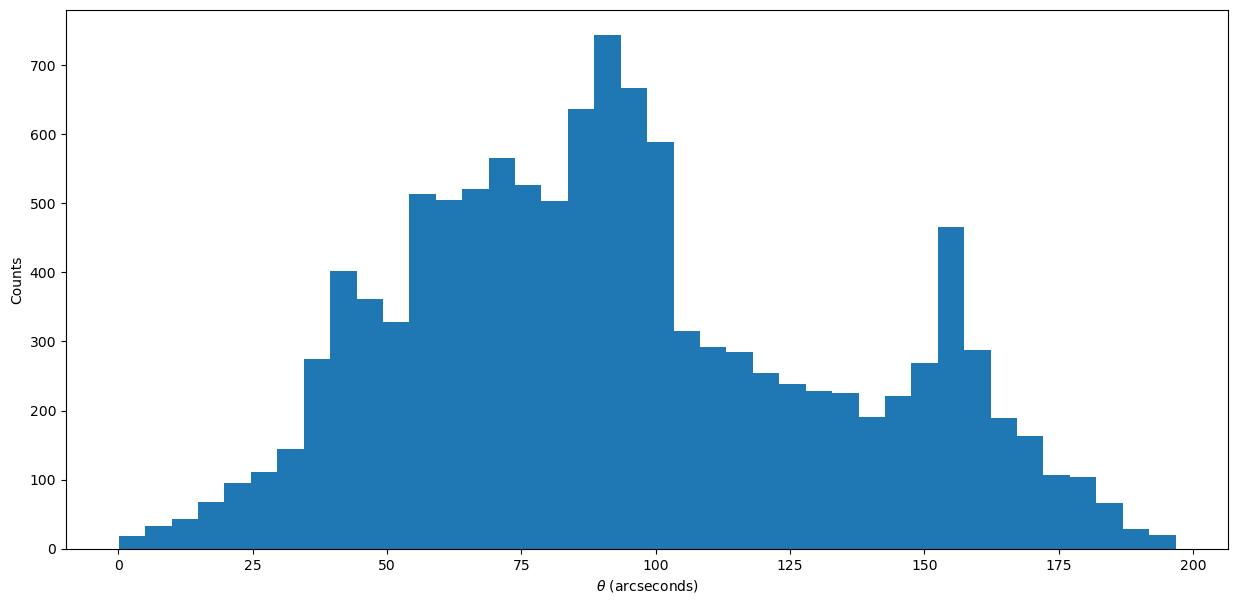

In [15]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.hist(df['theta'], bins=40)

ax.set_xlabel(r'$\theta$ (arcseconds)')
ax.set_ylabel('Counts')

In [16]:
theta_partitions = [0,50,100,150,200]

In [17]:
df_sorted = pd.DataFrame(columns=df.columns)

In [18]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df.loc[(df['theta']>=theta_min)&(df['theta']<=theta_max)].sort_values('f814w_mag')
        
    df_sorted = df_sorted.append(df_slice)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4221/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4221/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4221/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4221/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.a

Now, retain only the galaxies between a magnitude of 14 and 21

In [19]:
df_gals = df_sorted.loc[((df_sorted['f814w_mag']>=14)&(df_sorted['f814w_mag']<=21))&(df_sorted['alignment_star']==-1.0)]

In [20]:
df_gals = df_gals.append(df.loc[[709, 863, 1284, 1497, 1720,
                                 782, 561, 549, 420, 2400, 
                                 1707, 2697, 2601, 2682, 2633, 2852]])

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4221/3936126659.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gals = df_gals.append(df.loc[[709, 863, 1284, 1497, 1720,


In [21]:
df_gals

,ID,RA,Dec,f814w_mag,alignment_star,theta
750,751,125.186744,3.965137,16.33,-1.0,30.855137
6952,1138,125.199560,3.952235,18.85,-1.0,37.373544
1137,1138,125.192638,3.961605,18.85,-1.0,6.459124
6700,886,125.197656,3.949458,19.00,-1.0,44.035363
885,886,125.183683,3.954236,19.00,-1.0,46.041090
...,...,...,...,...,...,...
2697,2698,125.188896,3.978039,24.78,-1.0,63.585861
2601,2602,125.188403,3.978254,23.04,-1.0,64.889214
2682,2683,125.188073,3.978047,23.34,-1.0,64.594214
2633,2634,125.187651,3.978275,21.30,-1.0,65.905193


In [22]:
ra_sorted = []
dec_sorted = []
theta_sorted = []
mag_sorted = []

In [23]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df_gals.loc[(df_gals['theta']>=theta_min)&(df_gals['theta']<=theta_max)].sort_values('f814w_mag')
                
    theta_sorted.append(list(df_slice['theta']))
    mag_sorted.append(list(df_slice['f814w_mag']))
    ra_sorted.append(list(df_slice['RA']))
    dec_sorted.append(list(df_slice['Dec']))

Plot the distribution of galaxy magnitudes in each bin away from the quasar

In [24]:
colors = ['salmon', 'olive', 'sandybrown', 'lightblue', 'violet']

In [25]:
N_gals = 0

36
91
26
28


Text(0, 0.5, 'Magnitude')

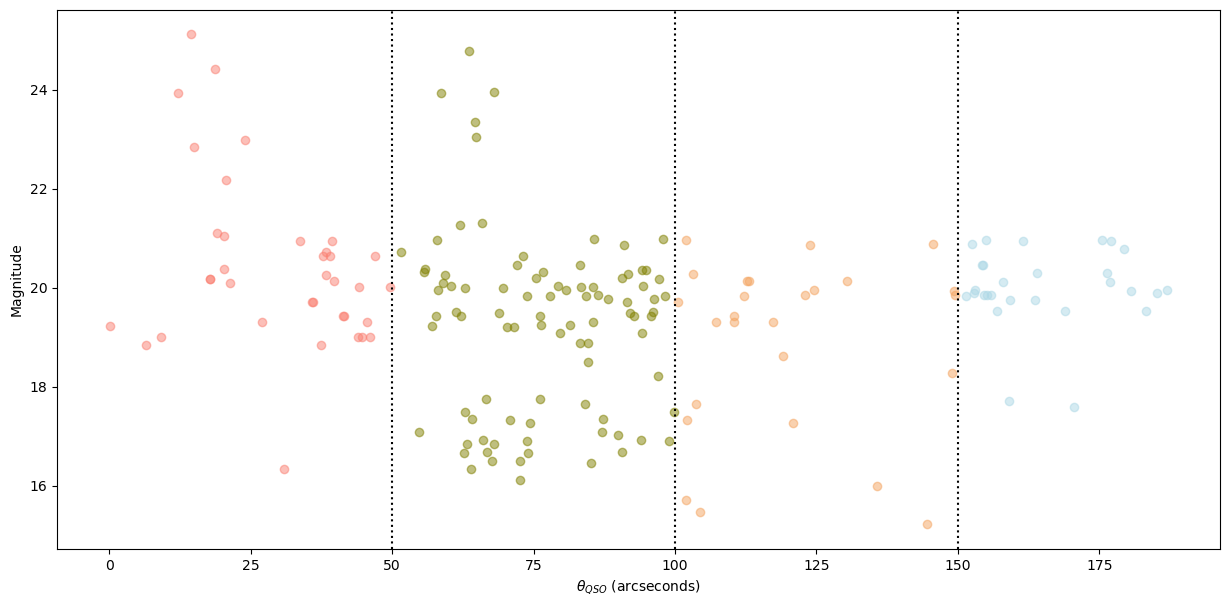

In [26]:
fig, ax = plt.subplots(1, figsize=(15,7))

for i in range(len(theta_sorted)):
    print(len(theta_sorted[i]))
    N_gals += len(theta_sorted[i])
    ax.scatter(theta_sorted[i], mag_sorted[i], color=colors[i], alpha=.5)
    
for j in range(1,len(theta_partitions)-1):
    ax.axvline(theta_partitions[j], color='black', linestyle=':')


ax.set_xlabel(r'$\theta_{QSO}$ (arcseconds)')
ax.set_ylabel('Magnitude')

Isolate the alignment stars

In [27]:
df_alignment_stars = df_sorted.loc[((df_sorted['alignment_star']==1.0)&(df_sorted['f814w_mag']>17)&(df_sorted['f814w_mag']<20))]

In [28]:
df_alignment_stars

,ID,RA,Dec,f814w_mag,alignment_star,theta
12,13,125.201815,3.950796,17.27,1.0,46.105691
1,2,125.195620,3.945078,17.09,1.0,58.388870
9,10,125.191519,3.934731,17.33,1.0,96.033231
2,3,125.192319,3.939630,17.35,1.0,78.198202
3652,3653,125.177906,3.984820,17.03,1.0,103.481319
5510,5511,125.153045,3.964267,17.59,1.0,148.922961
4,5,125.190404,3.933479,17.64,1.0,101.006188
4930,4931,125.154427,3.967076,17.70,1.0,145.086638
2230,2231,125.170360,3.946842,18.21,1.0,100.729117
4538,4539,125.160858,3.966690,18.28,1.0,122.049731


Next, the galaxies. First assign priority scores to the galaxies. The brightest galaxy in the closest bin to the quasar will have a priority of -1, while the dimmest will have a priority of +1.

In [29]:
priorities_sorted = []

In [30]:
count = 0
bin_size = len(theta_sorted[0])

for i in range(len(theta_sorted)):
    priorities_sorted.append([])
    for j in range(len(theta_sorted[i])):
        
        priorities_sorted[i].append(-1 + 2*(count/(bin_size-1)))
        
        # This puts the brightest closest galaxy at -1 and the dimmest farthest at 1
        #priorities_sorted[i].append(-1 + 2*(count/(N_gals-1)))
        count += 1

Write a regions file to visalize this properly

In [31]:
colors_ds9 = ['pink', 'green', 'yellow', 'cyan', 'white']

In [32]:
with open(rootdir+'ldss_galaxies.reg', 'w') as f:
    
    # Make the annular regions
    #for i in range(1, len(theta_partitions)-1):
    #    f.write('\ncircle(08:20:46.2, +03:57:42.1, {}") #color = gray'.format(theta_partitions[i]))
        
    f.write('#RA Dec Mag')
    # Mark the alignment stars
    for i in range(len(df_alignment_stars)):

        idx = df_alignment_stars.index[i]

        ra = Angle(df_alignment_stars.loc[idx,'RA'], units.deg).hms
        dec = Angle(df_alignment_stars.loc[idx,'Dec'], units.deg).dms
        mag = df_alignment_stars.loc[idx,'f814w_mag']

        ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
        dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

        f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color=' + 'red' + ' text={'+'%.4f'%np.round(mag, 2)+'}')

    # Mark the galaxies
    for i in range(len(ra_sorted)):

        ra_list = ra_sorted[i]
        dec_list = dec_sorted[i]
        mag_list = mag_sorted[i]
        theta_list = theta_sorted[i]
        priorities_list = priorities_sorted[i]

        for j in range(len(ra_list)):

            ra = Angle(ra_list[j], units.deg).hms
            dec = Angle(dec_list[j], units.deg).dms
            mag = mag_list[j]
            theta = theta_list[j]
            p = priorities_list[j]

            ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
            dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

            f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color='+colors_ds9[i]+' text={'+'%.2f'%np.round(mag, 2)+','+'%.2f'%np.round(theta, 2)+','+'%.2f'%np.round(p, 2)+'}')    
    
            
            